# Question 2:  Pose Graph Optimization for 2D SLAM

## Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

## Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:

1. Initial position
2. Odometry Contraints/Edges: This "edge" information tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges: Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` (in `data/`) which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://saishubodh.notion.site/G2O-Edge-Types-d9f9ff63c77c4ceeb84b1e49085004e3) ). The ground truth is `gt.txt`.

## Steps:

### Part 1

Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](../misc/robot-poses-MR-P1.png)

(Use `draw()` helper function or `g2o_viewer` or `EVO`)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import os
import jax.numpy as jnp
import jax

In [2]:
def read_vertex(fname):

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in open(fname):
        if "VERTEX_SE2" in line:
            gg = line.split()
            x_arr.append(float(gg[2]))
            y_arr.append(float(gg[3]))
            theta_arr.append(float(gg[4].rstrip('\n')))
            
    vertex = jnp.array([x_arr, y_arr, theta_arr])
    return vertex

def read_edge(fname):

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in open(fname):
        if "EDGE_SE2" in line:
            gg = line.split()
            ind1_arr.append(int(gg[1]))
            ind2_arr.append(int(gg[2]))
            del_x.append(float(gg[3]))
            del_y.append(float(gg[4]))
            del_theta.append(float(gg[5]))
            
    edges = [jnp.array(ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta)]
    return edges
            
vertex = read_vertex('../data/edges.txt')
edges = read_edge('../data/edges.txt')

print("Starting vertex is ["+str(vertex[0][0])+", "+str(vertex[1][0])+", "+str(vertex[2][0])+"].")
print("Got "+str(edges[0].size)+" edges in total.")

Starting vertex is [-5.0, -8.0, 0.0].
Got 139 edges in total.


In [3]:
def draw(X, Y, THETA):
    plt.clf()
    ax = plt.subplot(111)
    ax.plot(X, Y, 'bo')
    plt.plot(X, Y, 'c-')
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'r->')
    plt.show()

Odometry: 


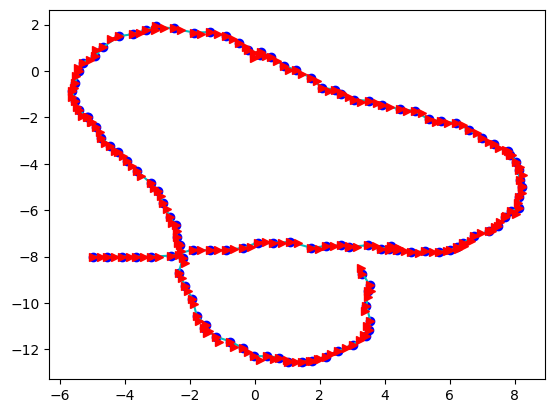

Ground truth: 


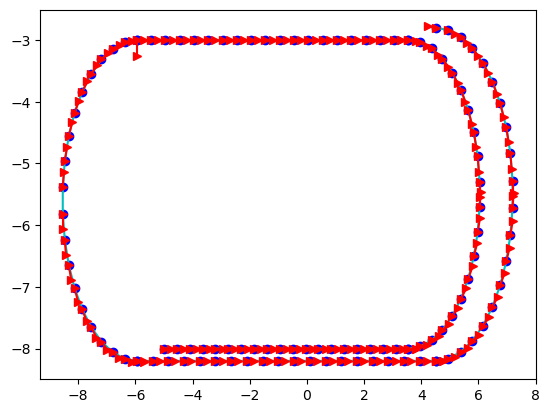

In [4]:
x = vertex[0][0]
y = vertex[1][0]
theta = vertex[2][0]
pose = [x, y, theta]
pose = jnp.array(pose)
poses = [pose]

for i in range(edges[0].size):
    
    if abs(edges[0][i] - edges[1][i]) != 1:
        pass
    
    else:
        del_x = edges[2][i]
        del_y = edges[3][i]
        del_theta = edges[4][i]
        x_new = x + del_x * jnp.cos(theta) - del_y * jnp.sin(theta)    # do using rotation matrix later
        y_new = y + del_y * jnp.cos(theta) + del_x * jnp.sin(theta)
        theta_new = theta + del_theta
        x = x_new
        y = y_new
        theta = theta_new
        pose = [x, y, theta]
        pose = jnp.array(pose)
        poses.append(pose)
        
poses = jnp.array(poses)

print("Odometry: ")
draw(poses[:,0], poses[:,1], poses[:,2])            # demoss later

vertex1 = read_vertex('../data/gt.txt')
vertex1 = jnp.array(vertex1)
vertex1 = vertex1.T
print("Ground truth: ")
draw(vertex1[:,0], vertex1[:,1], vertex1[:,2])



In [5]:
with open('edges-poses.g2o', 'w') as f:
    for i in range(poses.shape[0]):
        ind = i
        x = poses[i][0]
        y = poses[i][1]
        theta = poses[i][2]
        ln = "VERTEX_SE2 " + str(ind) + " " + str(x) + " " + str(y) + " " + str(theta)
        f.write("%s\n" % ln)
        
    for line in open('../data/edges.txt'):
        if "VERTEX_SE2" not in line:
            f.write("%s" % line)
                
f.close()

## Part 2

Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster. You can also visualise your Jacobian and see the structure of the matrix (just use `plt.imshow`).

**Regarding LM iterations, stopping criterion, information matrix values.**

1. As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notes on non-linear LS)](https://saishubodh.notion.site/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).

2. You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

3. You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (seen later on), you will be getting a close to ground truth trajectory.

In [6]:
# plot trajectory using matplotlib
def draw_traj(X, Y, THETA):
    ax = plt.subplot(111)
    gt_poses = read_vertex('../data/gt.txt')
    gt_poses = gt_poses.T
    
    ax.plot(gt_poses[:,0], gt_poses[:,1], 'ro')
    ax.plot(gt_poses[:,0], gt_poses[:,1], 'c-')
    
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(gt_poses[i][3]) + gt_poses[i][0]
        y2 = 0.25*math.sin(gt_poses[i][3]) + gt_poses[i][1]
        plt.plot([gt_poses[i][0], x2], [gt_poses[i][1], y2], 'b->')
    
    for i in range(len(THETA)):
        x2 = 0.25*math.cos(poses[i][3]) + poses[i][0]
        y2 = 0.25*math.sin(poses[i][3]) + poses[i][1]
        plt.plot([poses[i][0], x2], [poses[i][1], y2], 'r->')
    
    ax.plot(X, Y, 'ro')
    ax.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')
        
    blue_patch = mpatches.Patch(color='blue', label='Ground Truth')
    red_patch = mpatches.Patch(color='red', label='Initial Estimate')
    green_patch = mpatches.Patch(color='green', label='Optimised Trajectory')
    plt.legend(handles=[blue_patch, red_patch, green_patch])
    plt.show()

In [7]:
def jacobian(current_poses, edges):
    num_constraints = 3 + 3*edges[0].size
    num_variables = 3*current_poses.shape[0]
    
    J = jnp.zeros((num_constraints, num_variables))
        
    J = jax.ops.index_update(
            J, 
            jax.ops.index[:3, :3], 
            jnp.eye(3)
            )
    
    for i in range(edges[0].size):
        
        start_row = 3 + 3*i
        [x_i, y_i, theta_i] = poses[edges[0][i]]
        
        # This is for the subtraction
        # There are three -1 terms, one each for x, y, theta
        J = jax.ops.index_update(
                J,
                jax.ops.index[start_row : 3 + start_row, edges[1][i]*3: 3 + edges[1][i]*3],
                -1 * jnp.eye(3)
            )
        
        # This is for the transformation
        # There are 5 terms in total, 1 wrt x, 1 wrt y, and 3 wrt theta
        result = jnp.eye(3)
        result = jax.ops.index_update(result, 
                                      jax.ops.index[0, 2], 
                                      - del_x * jnp.sin(theta_i) - del_y * jnp.cos(theta_i))    
        result = jax.ops.index_update(result, 
                                      jax.ops.index[1, 2], 
                                      - del_y * jnp.sin(theta_i) + del_x * jnp.cos(theta_i))

        J = jax.ops.index_update(
                J,
                jax.ops.index[start_row : 3 + start_row, edges[0][i]*3: 3 + edges[0][i]*3],
                result
            )
    
    return J

def residual(current_poses, edges, start_point):
    
    residue = []
    residue.extend(list(current_poses[0] - start_point))

    for i in range(edges[0].size):
        [x, y, theta] = current_poses[edges[0][i]]
        del_x = edges[2][i]
        del_y = edges[3][i]
        del_theta = edges[4][i]
        x_new = x + del_x * jnp.cos(theta) - del_y * jnp.sin(theta)
        y_new = y + del_y * jnp.cos(theta) + del_x * jnp.sin(theta)
        theta_new = theta + del_theta
        residue.extend([float(x_new)-current_poses[edges[1][i]][0], 
                        float(y_new)-current_poses[edges[1][i]][1], 
                        float(theta_new)-current_poses[edges[1][i]][2]])
    
    return jnp.asarray(residue)

In [11]:
def optimise_lm(poses, edges, start_point, max_itr, odo_certainity, loop_certainity, start_certainity):
    
    lamda = 1
    tol = 1e-6
    all_errors = []
    
    certainities = [start_certainity, start_certainity, start_certainity]
    
    for i in range(edges[0].size):
        if abs(edges[0][i]-edges[1][i]) != 1:
            certainities.append(loop_certainity)
            certainities.append(loop_certainity)
            certainities.append(loop_certainity)
        else:
            certainities.append(odo_certainity)
            certainities.append(odo_certainity)
            certainities.append(odo_certainity)   
            
    weights = jnp.diag(jnp.array(certainities))
    
    all_poses = [poses]
    
    res = residual(poses, edges, start_point)
    err = 0.5 * res.T@weights@res
    all_errors.append(err) 

    print('Iteration: 0')
    print('Error: '+str(err))
    draw_traj(poses[:, 0], poses[:, 1], poses[:, 2])
    
    for _ in range(max_itr):

        J = jacobian(poses, edges)
        res = residual(poses, edges, start_point)
        step = - jnp.linalg.inv(J.T @ weights @ J + lamda * jnp.eye(J.shape[1])) @ J.T @ weights.T @ res
        new_poses = poses + step.reshape((-1, 3))
    
        res = residual(poses, edges, start_point)
        err = 0.5 * (res.T@weights@res)
        
        print('Iteration: '+str(_+1))
        print('Error: '+str(err))
        
        if (_+1)%10==0 or _+1==max_itr:
            draw_traj(new_poses[:, 0], new_poses[:, 1], new_poses[:, 2])
        
        else:
            print()

        if len(all_errors) > 0:
            if (err > all_errors[-1]):
                lamda = lamda * 2
            else:
                lamda = lamda / 3
                
        all_errors.append(err)
        all_poses.append(new_poses)
        
        if err < 40 or jnp.linalg.norm(new_poses - poses) < tol:
            draw_traj(new_poses[:, 0], new_poses[:, 1], new_poses[:, 2])
            poses = new_poses
            break
        
        poses = new_poses
        
    return all_poses, all_errors

# draw_traj, step_lm <--- jacobian

Iteration: 0
Error: 913388.75


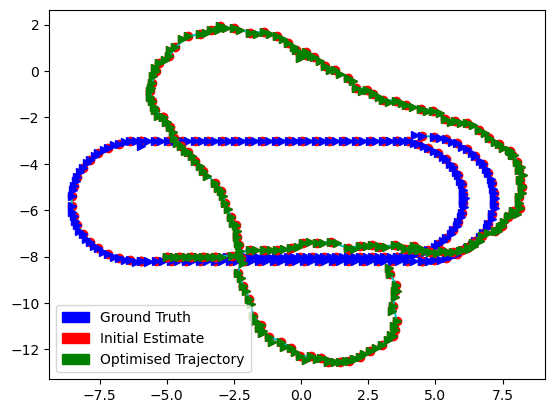

Iteration: 1
Error: 913388.75

Iteration: 2
Error: 55101.25

Iteration: 3
Error: 5834.008

Iteration: 4
Error: 2927.5273

Iteration: 5
Error: 1074.3934

Iteration: 6
Error: 1090.7388

Iteration: 7
Error: 649.0264

Iteration: 8
Error: 477.16772

Iteration: 9
Error: 424.02936

Iteration: 10
Error: 397.07123


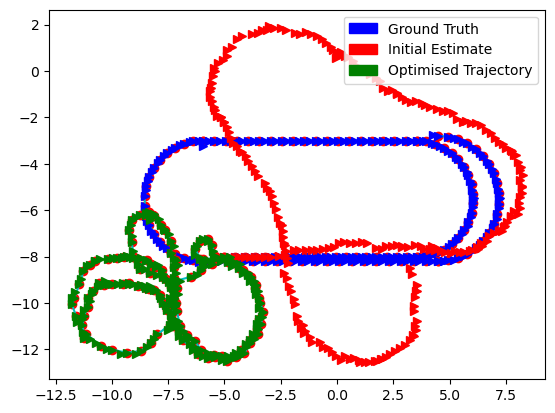

Iteration: 11
Error: 377.0039

Iteration: 12
Error: 361.43152

Iteration: 13
Error: 349.24634

Iteration: 14
Error: 339.6412

Iteration: 15
Error: 332.10516

Iteration: 16
Error: 326.32156

Iteration: 17
Error: 322.1206

Iteration: 18
Error: 319.4425

Iteration: 19
Error: 318.32535

Iteration: 20
Error: 318.90482


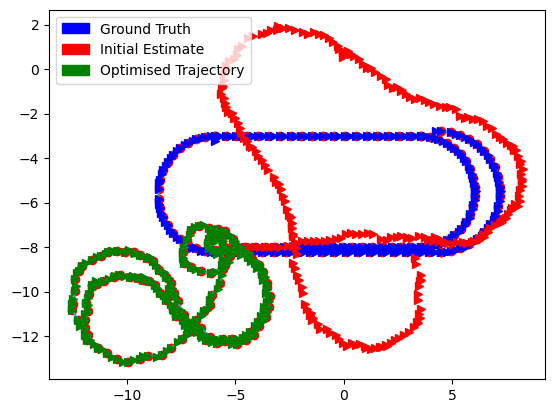

Iteration: 21
Error: 321.4365

Iteration: 22
Error: 326.3334

Iteration: 23
Error: 334.22873

Iteration: 24
Error: 346.06085

Iteration: 25
Error: 363.18695

Iteration: 26
Error: 387.48584

Iteration: 27
Error: 421.3809

Iteration: 28
Error: 467.64502



In [ ]:
odo_certainity = 100
loop_certainity = 1000
start_certainity = 2000
max_itr = 100

poses_history, errors_history = optimise_lm(poses, 
                                            edges, 
                                            poses[0, :], 
                                            max_itr, 
                                            odo_certainity, 
                                            loop_certainity, 
                                            start_certainity)

**Tip**

Be sure to make your code modular and implement this in various stages. It will help you debug errors. Feel free to create helper functions in other files, just be sure to submit those as well. 

You are free to optimise your code using numba/Jax/torch if you wish, just ensure that you are not using any built in functions for any of the steps. It is only compulsory to verify your Jacobian using Jax.

## Part 3

- Write about the residuals you computed, its structure and shape. Also explain the structure of the Jacobian and its shape (Express the shape in terms of the number of vertices, loop constraints, and such, not exact numbers). 
- Write about the optimization process and any observations using intermediate plots and such. 

## Part 4

Write the final optimised trajectory as a g2o file. You can do this alongside any of the earlier parts.